In [1]:
import sys, os

src = r"C:\Users\user\Desktop\Coding mo\AutoML proj1\task 1\AutoML Project Molham\src" # copy the location of the folder that has paths.py file using (ctrl + shift + C ) and paste it here    
sys.path.append(src)

from paths import *

get_paths()

sys.path.append(SRC_PATH)

from boosting_models import *
from pipeline import *


In [2]:
# ---------------- Task 2+9 ----------------

def loop_dfs_and_evaluate_catboost():
    for dataset_file in data_dict_classification_only.keys():
        dataset_summary = []
        runtime_memory_rows = []
        dataset_base = os.path.splitext(dataset_file)[0]

        for seed in RANDOM_SEEDS:
            np.random.seed(seed)
            random.seed(seed)

            df_train = splits_dict[dataset_file]['train']
            df_test = splits_dict[dataset_file]['test']
            target_col = TARGET_COLS[dataset_file]

            X_train = df_train.drop(columns=[target_col])
            y_train = df_train[target_col]
            X_test = df_test.drop(columns=[target_col])
            y_test = df_test[target_col]

            start_time = time.time()
            model = CatBoostClassifier(
                random_seed=seed,
                iterations=300,
                learning_rate=0.1,
                depth=6,
                verbose=0
            )
            
            cat_features = [col for col in X_train.columns if X_train[col].dtype.name == 'category']

            model.fit(X_train, y_train, cat_features=cat_features)
            training_runtime_sec = round(time.time() - start_time, 3)

            temp_model_file = os.path.join("temp_catboost_models", f"{dataset_base}_{seed}.pkl")
            os.makedirs("temp_catboost_models", exist_ok=True)
            with open(temp_model_file, "wb") as f:
                pickle.dump(model, f)
            total_bytes = os.path.getsize(temp_model_file)
            model_size_mb = round(total_bytes / (1024 * 1024), 3)
            os.remove(temp_model_file)

            memory_usage_mb = get_memory_usage_mb()

            results = evaluate_and_save_results_boosting(df_train, df_test, model, dataset_file)

            runtime_memory_rows.append({
                "dataset": dataset_file,
                "seed": seed,
                "training_runtime_sec": training_runtime_sec,
                "model_size_MB": model_size_mb,
                "memory_usage_MB": memory_usage_mb
            })

            dataset_summary.append({
                'dataset': dataset_file,
                'seed': seed,
                **results,
                'runtime': training_runtime_sec
            })

            del model
            gc.collect()

        output_path = os.path.join(BOOSTINGS_PATH, f"catboost_{dataset_base}_summary.csv")
        pd.DataFrame(dataset_summary).to_csv(output_path, index=False)

        task2_output_path = os.path.join(RUNTIME_MEMORY_TASK2_BOOSTINGS_PATH,f"catboost_{dataset_base}_task2_runtime_memory_metrics.csv") 
        pd.DataFrame(runtime_memory_rows).to_csv(task2_output_path, index=False)


loop_dfs_and_evaluate_catboost()




In [3]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    
    csv_file1 = os.path.join(BOOSTINGS_PATH, f"catboost_{dataset_base}_summary.csv")
    csv_file2 = os.path.join(RUNTIME_MEMORY_TASK2_BOOSTINGS_PATH, f"catboost_{dataset_base}_task2_runtime_memory_metrics.csv")

    print(f"CSV for {dataset_name.replace('.csv', '')}: catboost_{dataset_base}_summary.csv")
    df1 = pd.read_csv(csv_file1)
    display(df1)

    print(f"CSV for {dataset_name.replace('.csv', '')}: catboost_{dataset_base}_task1_runtime_memory_metrics.csv")
    df2 = pd.read_csv(csv_file2)
    display(df2)



CSV for modeldata: catboost_modeldata_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,modeldata.csv,42,0.931365,0.931478,0.931646,0.931365,3.820
1,modeldata.csv,123,0.929915,0.930089,0.930386,0.929915,4.055


CSV for modeldata: catboost_modeldata_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,modeldata.csv,42,3.820,0.349,7616.645
1,modeldata.csv,123,4.055,0.350,7680.129


CSV for titanic: catboost_titanic_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,titanic.csv,42,0.821229,0.818174,0.823022,0.821229,3.325
1,titanic.csv,123,0.815642,0.813462,0.815622,0.815642,3.288


CSV for titanic: catboost_titanic_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,titanic.csv,42,3.325,0.726,7200.059
1,titanic.csv,123,3.288,0.834,7200.477


CSV for train: catboost_train_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,train.csv,42,1.0,1.0,1.0,1.0,0.150
1,train.csv,123,1.0,1.0,1.0,1.0,0.149


CSV for train: catboost_train_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,train.csv,42,0.150,0.610,7200.941
1,train.csv,123,0.149,0.613,7201.211


CSV for wine: catboost_wine_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,wine.csv,42,1.0,1.0,1.0,1.0,0.261
1,wine.csv,123,1.0,1.0,1.0,1.0,0.276


CSV for wine: catboost_wine_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,wine.csv,42,0.261,0.619,7201.234
1,wine.csv,123,0.276,0.616,7201.262


In [4]:
# ---------------- Task 2+9 ----------------

from catboost import CatBoostClassifier, Pool

def loop_dfs_and_evaluate_catboost_tuned():
    for dataset_file in data_dict_classification_only.keys():
        dataset_summary = []
        runtime_memory_rows = []
        dataset_base = os.path.splitext(dataset_file)[0]

        for seed in RANDOM_SEEDS:
            np.random.seed(seed)
            random.seed(seed)

            df_train = splits_dict[dataset_file]['train'].copy()
            df_test = splits_dict[dataset_file]['test'].copy()
            target_col = TARGET_COLS[dataset_file]

            for col in df_train.columns:
                if df_train[col].dtype == "object":
                    df_train[col] = df_train[col].astype("category")
                    df_test[col] = df_test[col].astype("category")

            X_train = df_train.drop(columns=[target_col])
            y_train = df_train[target_col]
            X_test = df_test.drop(columns=[target_col])
            y_test = df_test[target_col]

            cat_features = [i for i, col in enumerate(X_train.columns) if str(X_train[col].dtype).startswith("category")
            ]

            param_grid = {
                'iterations': [200, 300, 500],
                'learning_rate': [0.01, 0.05, 0.1],
                'depth': [4, 6, 8],
                'l2_leaf_reg': [1, 3, 5],
                'border_count': [32, 64, 128]
            }

            model = CatBoostClassifier(
                random_seed=seed,
                verbose=0,
                thread_count=1
            )

            search = RandomizedSearchCV(
                model,
                param_distributions=param_grid,
                n_iter=5,
                scoring='accuracy',
                cv=2,
                random_state=seed,
                n_jobs=1,
                verbose=0
            )

            start_time = time.time()
            search.fit(X_train, y_train, cat_features=cat_features)
            training_runtime_sec = round(time.time() - start_time, 3)

            best_model = search.best_estimator_
            best_params = search.best_params_

            infer_start = time.time()
            results = evaluate_and_save_results_boosting(df_train, df_test, best_model, dataset_file)
            inference_runtime_sec = round(time.time() - infer_start, 6)

            temp_model_dir = "temp_catboost_tuned_models"
            os.makedirs(temp_model_dir, exist_ok=True)
            temp_model_file = os.path.join(temp_model_dir, f"{dataset_base}_{seed}.pkl")
            with open(temp_model_file, "wb") as f:
                pickle.dump(best_model, f)
            total_bytes = os.path.getsize(temp_model_file)
            model_size_mb = round(total_bytes / (1024 * 1024), 3)
            os.remove(temp_model_file)

            memory_usage_mb = get_memory_usage_mb()
            cpu_usage_percent = psutil.cpu_percent(interval=None)

            dataset_summary.append({
                "dataset": dataset_file,
                "seed": seed,
                **results,
                "training_runtime_sec": training_runtime_sec,
                "inference_runtime_sec": inference_runtime_sec,
                "best_params": str(best_params)
            })

            runtime_memory_rows.append({
                "dataset": dataset_file,
                "seed": seed,
                "training_runtime_sec": training_runtime_sec,
                "model_size_MB": model_size_mb,
                "memory_usage_MB": memory_usage_mb,
                "inference_time_per_sample_sec": inference_runtime_sec / len(X_test),
                "cpu_usage_percent": cpu_usage_percent
            })

            feature_importances = best_model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_features))
            importance_df = (
                pd.DataFrame({
                    'feature': X_train.columns,
                    'importance': feature_importances
                })
                .sort_values(by='importance', ascending=False)
                .head(15)
            )

            plt.figure(figsize=(14, 8))
            sns.barplot(data=importance_df, x='importance', y='feature')
            plt.title(f"CatBoost Tuned Feature Importance\n{dataset_file} (seed={seed})")
            plt.tight_layout()
            plot_file = os.path.join(
                FEATURE_IMPORTANCE_PATH,
                f"catboost_importance_{dataset_base}_seed{seed}.png"
            )
            plt.savefig(plot_file)
            plt.close()

            del X_train, X_test, y_train, y_test, model, search, best_model
            gc.collect()

        output_path = os.path.join(
            BOOSTINGS_TUNED_PATH,
            f"catboost_tuned_{dataset_base}_summary.csv"
        )
        pd.DataFrame(dataset_summary).to_csv(output_path, index=False)

        task2_output_path = os.path.join(
            RUNTIME_MEMORY_TASK2_BOOSTINGS_TUNED_PATH,
            f"catboost_tuned_{dataset_base}_runtime_memory_metrics.csv"
        )
        pd.DataFrame(runtime_memory_rows).to_csv(task2_output_path, index=False)

        json_path = os.path.join(
            RUNTIME_MEMORY_TASK2_BOOSTINGS_TUNED_PATH,
            f"catboost_tuned_{dataset_base}_runtime_memory_metrics_in_json.json"
        )
        with open(json_path, 'w') as f:
            json.dump(runtime_memory_rows, f, indent=2)


loop_dfs_and_evaluate_catboost_tuned()


CSV for modeldata: catboost_tuned_modeldata_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,modeldata.csv,42,0.931396,0.931548,0.931798,0.931396,74.986,0.052746,"{'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iter..."
1,modeldata.csv,123,0.926954,0.927065,0.927223,0.926954,60.950,0.051112,"{'learning_rate': 0.05, 'l2_leaf_reg': 1, 'ite..."


CSV for modeldata: catboost_tuned_modeldata_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,modeldata.csv,42,74.986,1.229,8176.305,0.000002,18.7
1,modeldata.csv,123,60.950,0.188,8189.352,0.000002,7.7


Feature Importance for modeldata (seed=42):


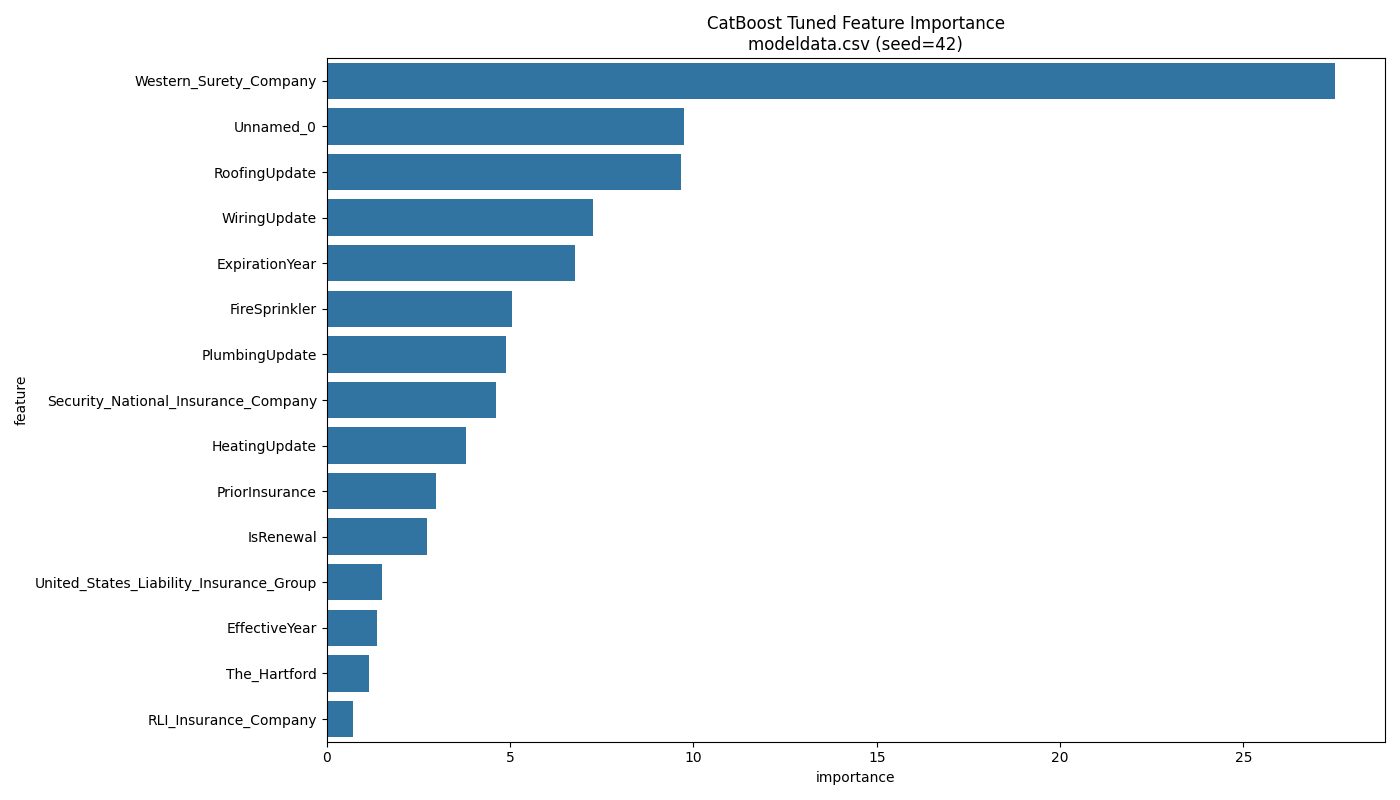

Feature Importance for modeldata (seed=123):


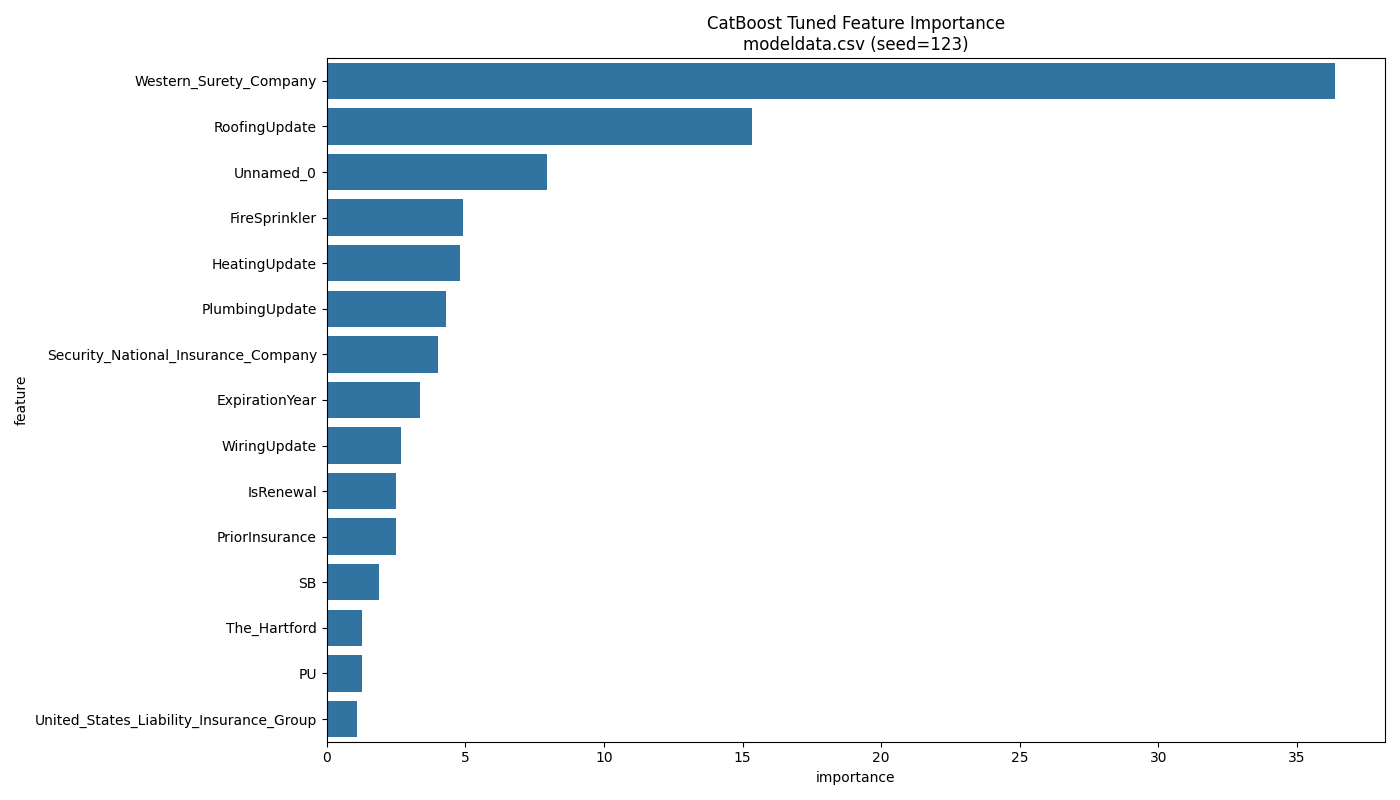

CSV for titanic: catboost_tuned_titanic_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,titanic.csv,42,0.810056,0.807491,0.810268,0.810056,57.727,0.008541,"{'learning_rate': 0.01, 'l2_leaf_reg': 5, 'ite..."
1,titanic.csv,123,0.832402,0.830139,0.833389,0.832402,34.003,0.013107,"{'learning_rate': 0.05, 'l2_leaf_reg': 1, 'ite..."


CSV for titanic: catboost_tuned_titanic_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,titanic.csv,42,57.727,0.493,7333.988,0.000048,9.7
1,titanic.csv,123,34.003,0.596,7338.406,0.000073,8.3


Feature Importance for titanic (seed=42):


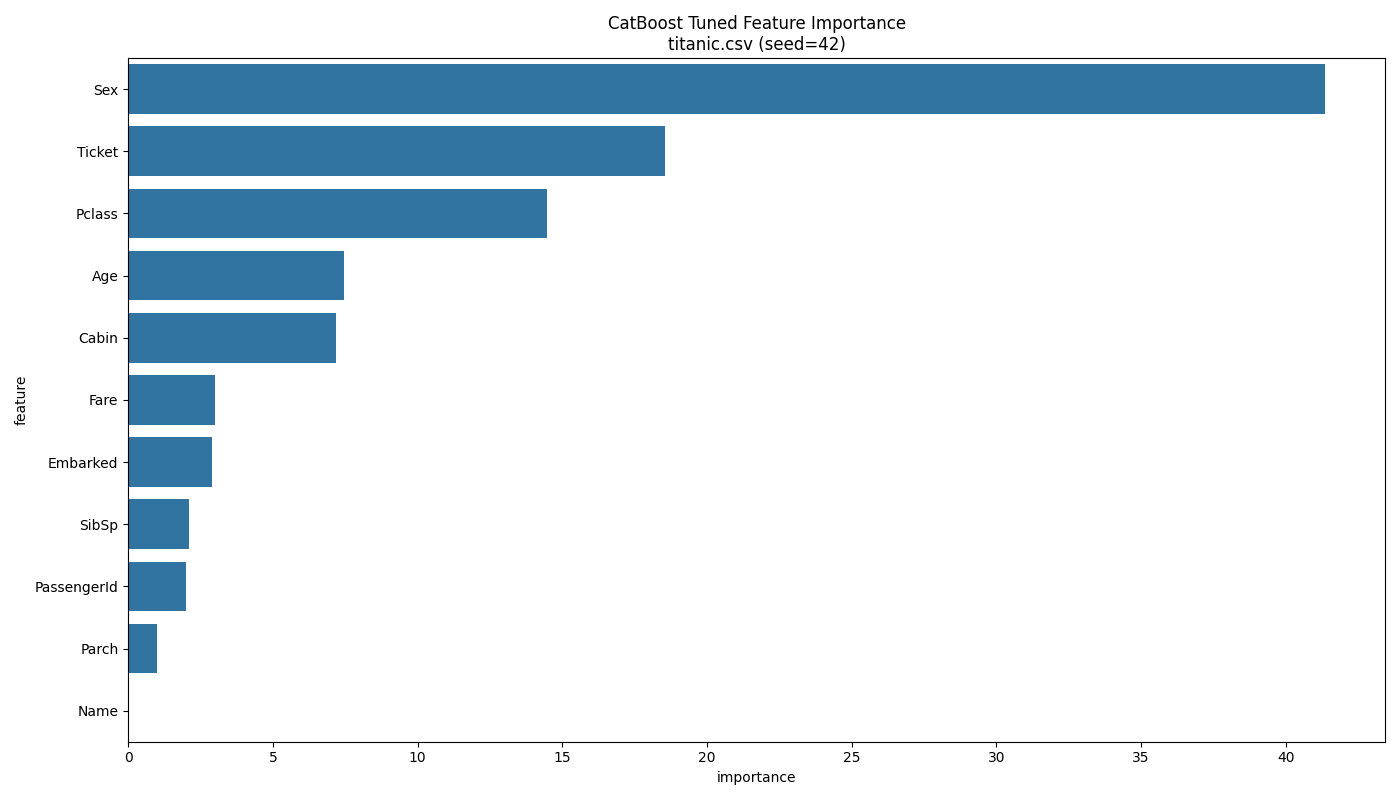

Feature Importance for titanic (seed=123):


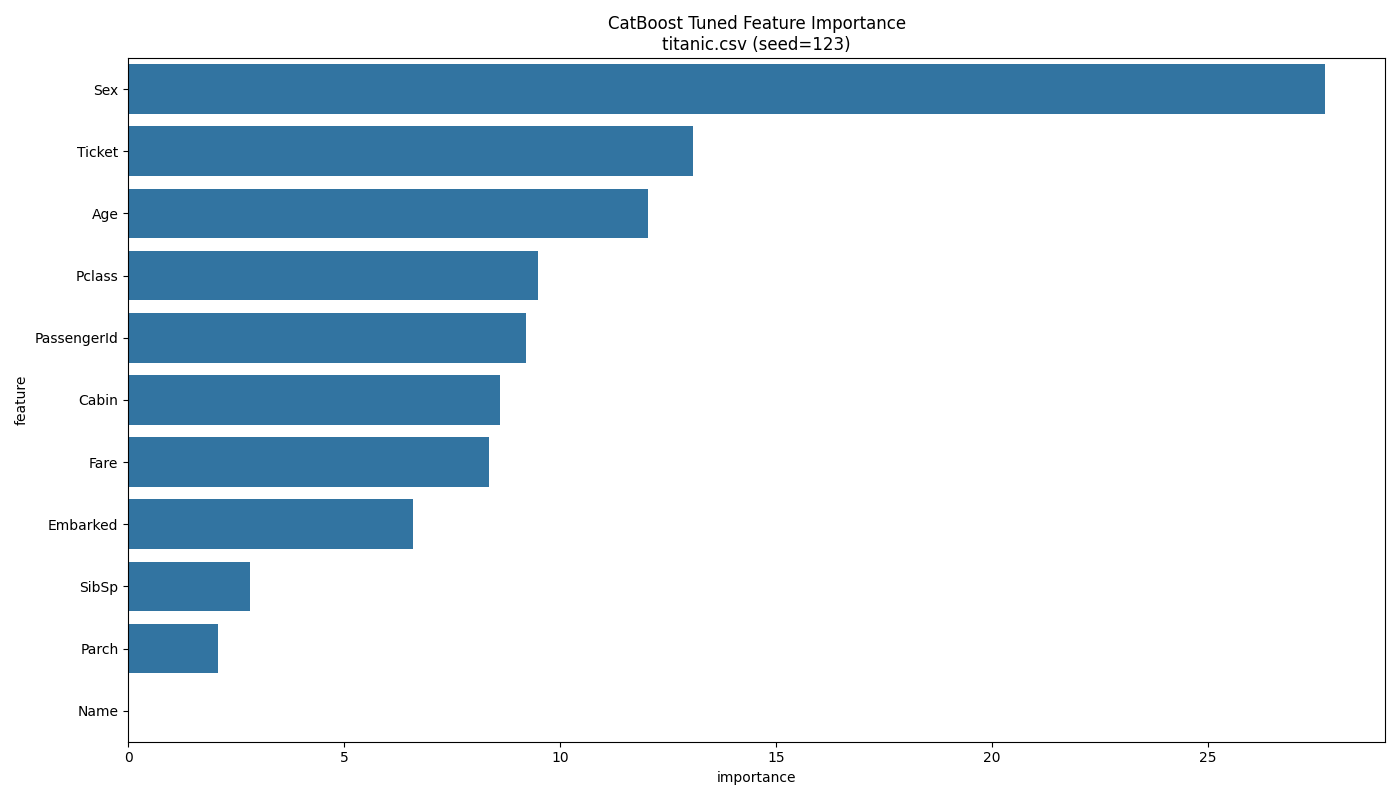

CSV for train: catboost_tuned_train_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,train.csv,42,1.0,1.0,1.0,1.0,3.707,0.006296,"{'learning_rate': 0.01, 'l2_leaf_reg': 5, 'ite..."
1,train.csv,123,1.0,1.0,1.0,1.0,2.213,0.009167,"{'learning_rate': 0.05, 'l2_leaf_reg': 1, 'ite..."


CSV for train: catboost_tuned_train_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,train.csv,42,3.707,0.283,7343.109,0.000210,8.2
1,train.csv,123,2.213,0.286,7347.652,0.000306,8.5


Feature Importance for train (seed=42):


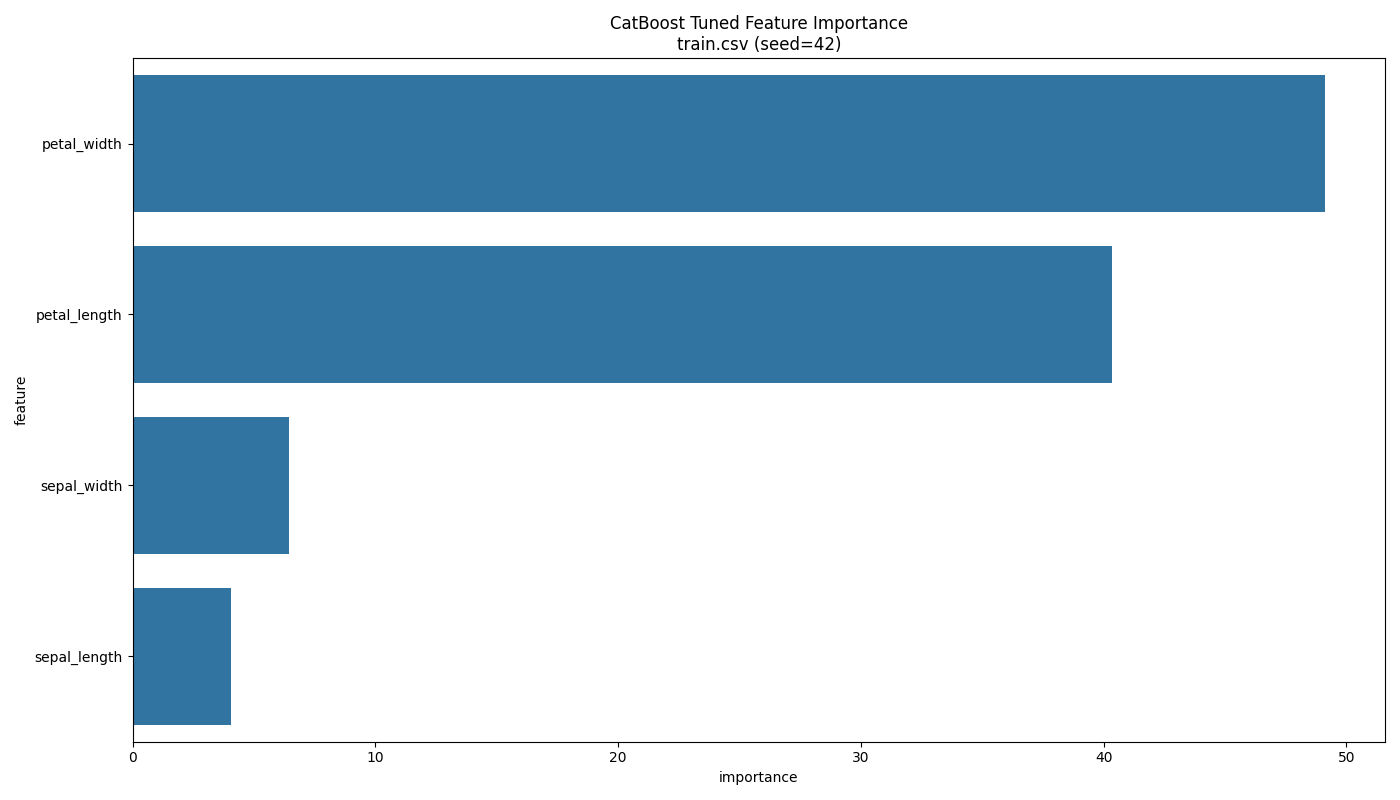

Feature Importance for train (seed=123):


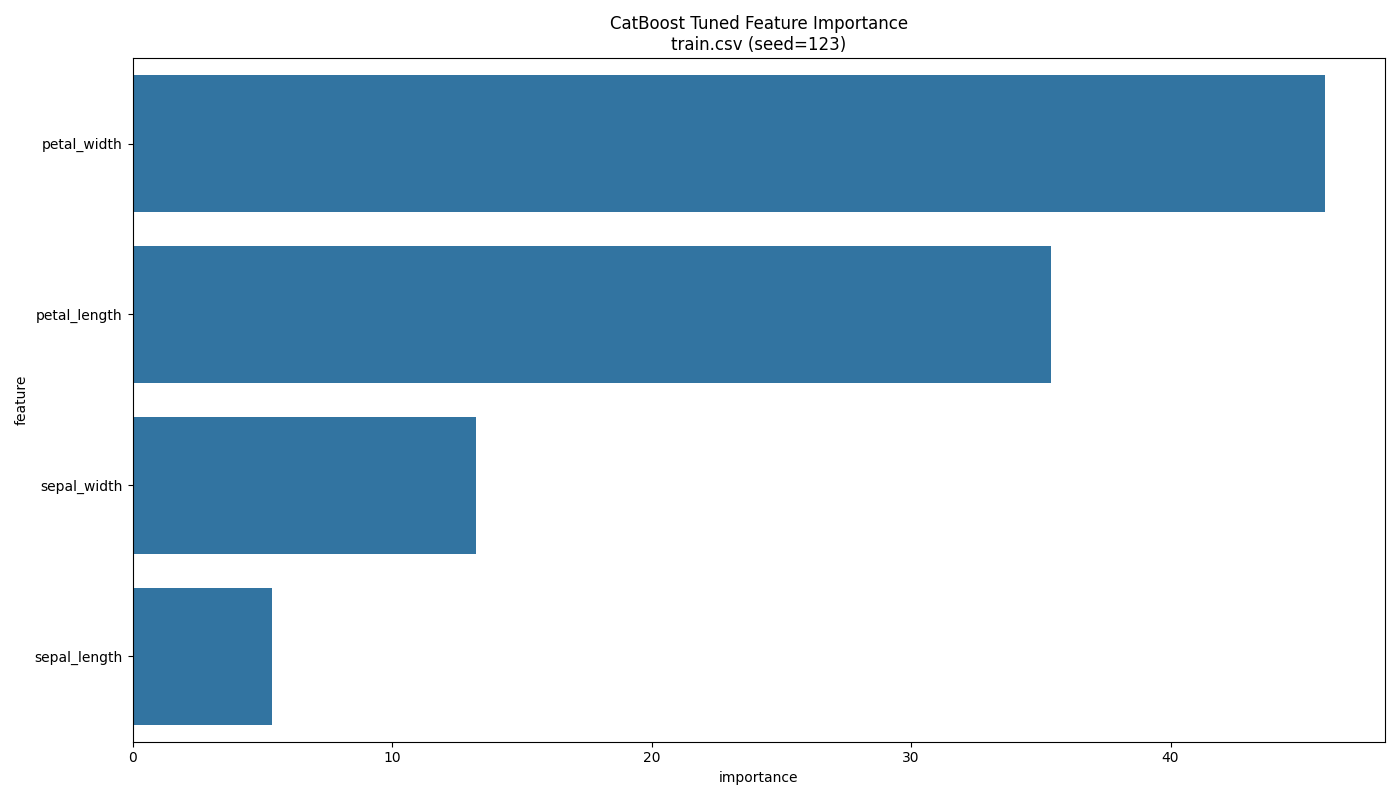

CSV for wine: catboost_tuned_wine_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,wine.csv,42,1.000000,1.000000,1.000000,1.000000,24.319,0.005469,"{'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iter..."
1,wine.csv,123,0.972222,0.972187,0.974074,0.972222,14.847,0.007259,"{'learning_rate': 0.01, 'l2_leaf_reg': 5, 'ite..."


CSV for wine: catboost_tuned_wine_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,wine.csv,42,24.319,2.352,7354.578,0.000152,7.6
1,wine.csv,123,14.847,1.538,7359.125,0.000202,8.4


Feature Importance for wine (seed=42):


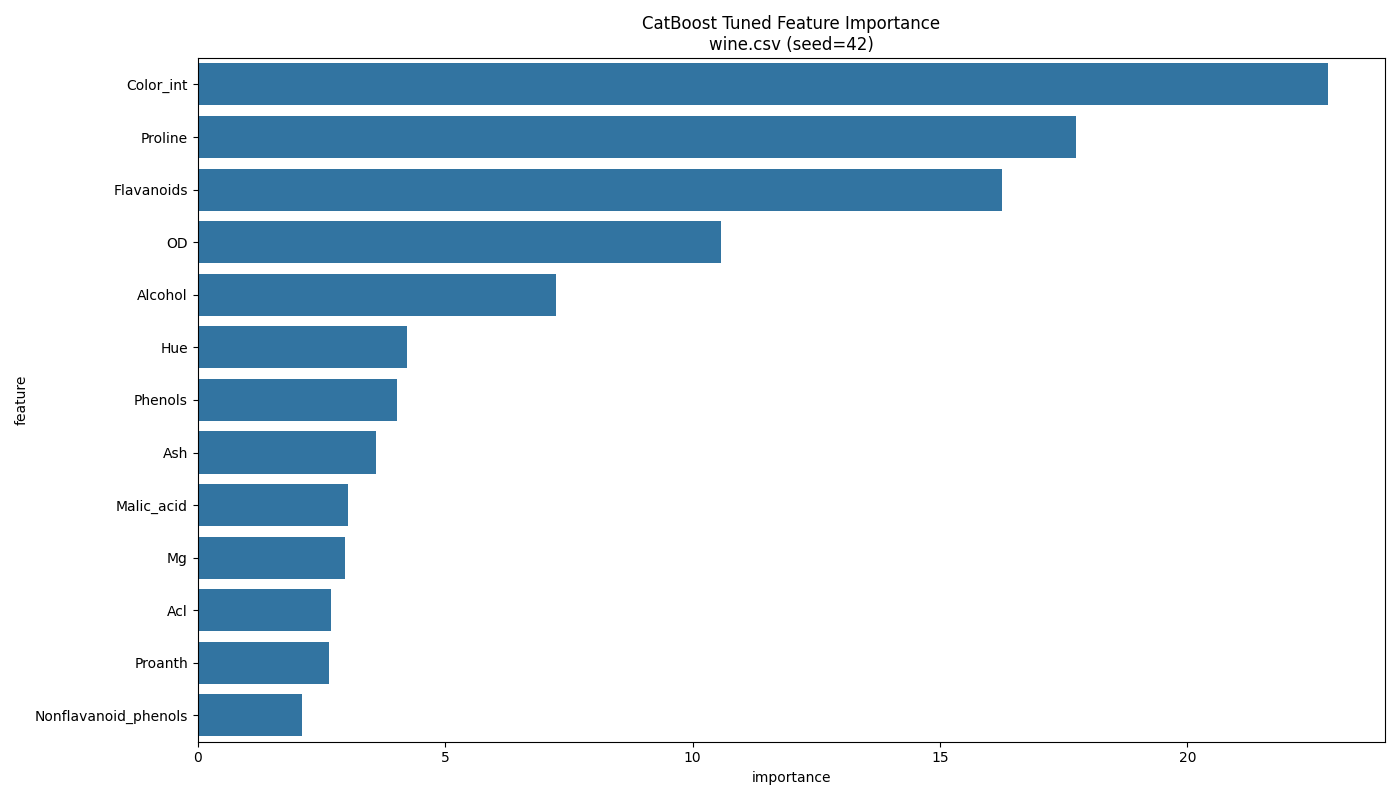

Feature Importance for wine (seed=123):


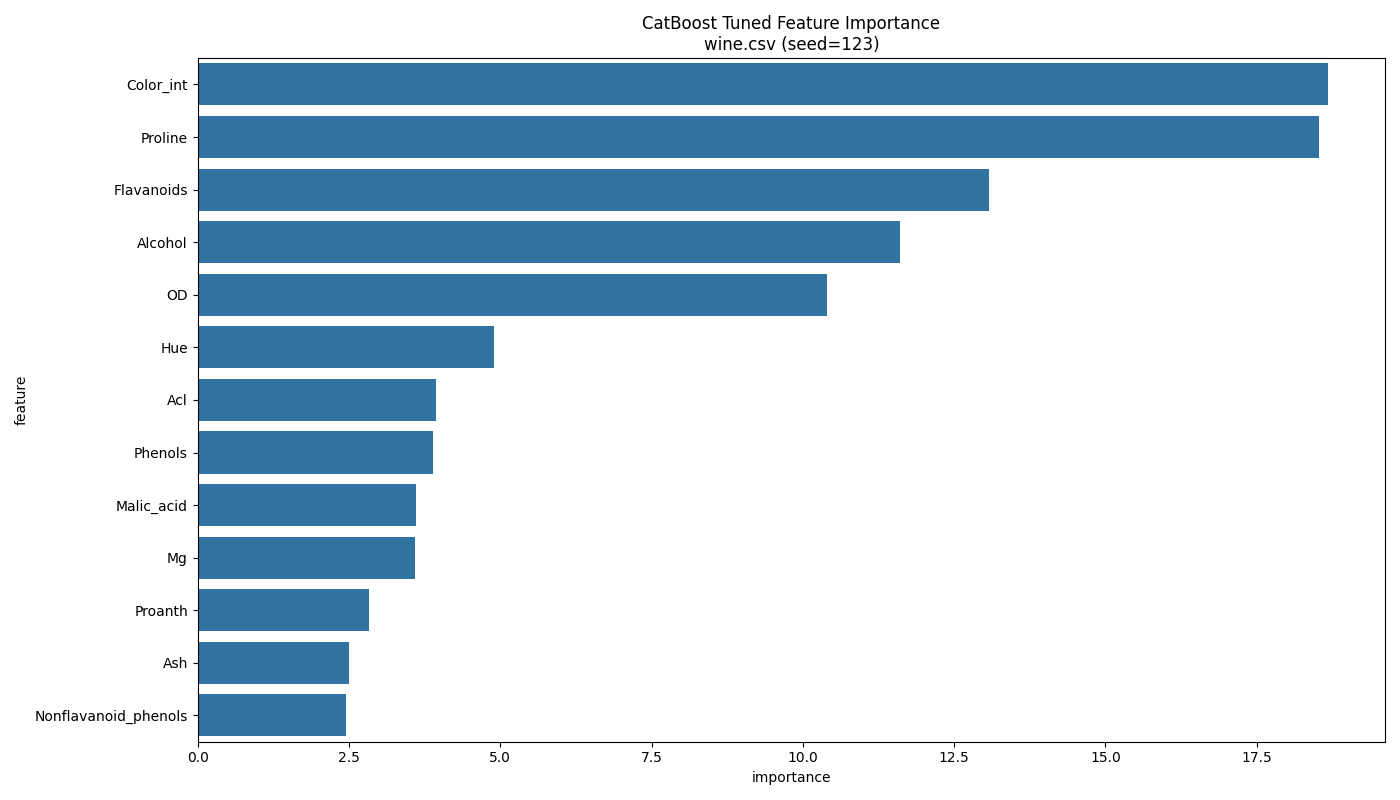

In [5]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    
    csv_file1 = os.path.join(BOOSTINGS_TUNED_PATH, f"catboost_tuned_{dataset_base}_summary.csv")
    csv_file2 = os.path.join(RUNTIME_MEMORY_TASK2_BOOSTINGS_TUNED_PATH, f"catboost_tuned_{dataset_base}_runtime_memory_metrics.csv")

    print(f"CSV for {dataset_base}: catboost_tuned_{dataset_base}_summary.csv")
    df1 = pd.read_csv(csv_file1)
    display(df1)

    print(f"CSV for {dataset_base}: catboost_tuned_{dataset_base}_runtime_memory_metrics.csv")
    df2 = pd.read_csv(csv_file2)
    display(df2)

    for seed in RANDOM_SEEDS:
        img_path = os.path.join(FEATURE_IMPORTANCE_PATH, f"catboost_importance_{dataset_base}_seed{seed}.png")
        if os.path.exists(img_path):
            print(f"Feature Importance for {dataset_base} (seed={seed}):")
            display(Image(filename=img_path))





In [6]:
# ---------------- Task 3+9 ----------------

from catboost import CatBoostClassifier

def evaluate_cv_folds_catboost(folds_dict):
    for dataset_file, folds_data in folds_dict.items():
        target_col = TARGET_COLS[dataset_file]
        summary = []
        runtime_memory_rows = []
        dataset_base = dataset_file.replace(".csv", "")

        for seed in RANDOM_SEEDS:
            np.random.seed(seed)
            random.seed(seed)
            fold_num = 1

            for fold_name, fold_splits in folds_data.items():
                df_train = fold_splits['train']
                df_val = fold_splits['val']

                X_train = df_train.drop(columns=[target_col])
                y_train = df_train[target_col]
                X_val = df_val.drop(columns=[target_col])
                y_val = df_val[target_col]

                for col in X_train.columns:
                    if X_train[col].dtype == "object":
                        X_train[col] = X_train[col].astype("category")
                        X_val[col] = X_val[col].astype("category")

                cat_features = [i for i, col in enumerate(X_train.columns) if str(X_train[col].dtype).startswith("category")]

                temp_dir = tempfile.mkdtemp()

                start_time = time.time()
                model = CatBoostClassifier(random_seed=seed, verbose=0, task_type="CPU")
                model.fit(X_train, y_train, cat_features=cat_features)
                preds = model.predict(X_val)
                training_runtime_sec = round(time.time() - start_time, 3)

                infer_start = time.time()
                results = evaluate_and_save_results_boosting(df_train, df_val, model, dataset_file)
                inference_time_per_sample = round((time.time() - infer_start) / len(X_val), 6)

                temp_model_file = os.path.join(temp_dir, f"{dataset_base}_{seed}_fold{fold_num}.pkl")
                with open(temp_model_file, "wb") as f:
                    pickle.dump(model, f)
                total_bytes = os.path.getsize(temp_model_file)
                model_size_mb = round(total_bytes / (1024 * 1024), 3)
                shutil.rmtree(temp_dir, ignore_errors=True)

                memory_usage_mb = get_memory_usage_mb()
                cpu_usage_percent = psutil.cpu_percent(interval=None)

                runtime_memory_rows.append({
                    "dataset": dataset_file,
                    "seed": seed,
                    "fold": fold_num,
                    "training_runtime_sec": training_runtime_sec,
                    "model_size_MB": model_size_mb,
                    "memory_usage_MB": memory_usage_mb,
                    "inference_time_per_sample_sec": inference_time_per_sample,
                    "cpu_usage_percent": cpu_usage_percent
                })

                summary.append({
                    "dataset": dataset_file,
                    "seed": seed,
                    "fold": fold_num,
                    **results,
                    "runtime": training_runtime_sec
                })

                fold_num += 1
                del model
                gc.collect()

        output_path = os.path.join(CV_FOLDS_METRICS_PATH, f"catboost_{dataset_base}_cv_summary.csv")
        pd.DataFrame(summary).to_csv(output_path, index=False)

        task3_output_path = os.path.join(RUNTIME_MEMORY_TASK3_PATH, f"catboost_{dataset_base}_task3_runtime_memory_metrics.csv")
        pd.DataFrame(runtime_memory_rows).to_csv(task3_output_path, index=False)

        json_path = os.path.join(RUNTIME_MEMORY_TASK3_PATH, f"catboost_{dataset_base}_runtime_memory_metrics_cv_in_json.json")
        with open(json_path, 'w') as f:
            json.dump(runtime_memory_rows, f, indent=2)

evaluate_cv_folds_catboost(folds_dict)


In [7]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    csv_file1 = os.path.join(CV_FOLDS_METRICS_PATH, f"catboost_{dataset_base}_cv_summary.csv")
    csv_file2 = os.path.join(RUNTIME_MEMORY_TASK3_PATH, f"catboost_{dataset_base}_task3_runtime_memory_metrics.csv")

    print(f"CSV for {dataset_base}: catboost_{dataset_base}_cv_summary.csv")
    df1 = pd.read_csv(csv_file1)
    display(df1)

    print(f"CSV for {dataset_base}: catboost_{dataset_base}_task3_runtime_memory_metrics.csv")
    df2 = pd.read_csv(csv_file2)
    display(df2)



CSV for modeldata: catboost_modeldata_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,modeldata.csv,42,1,0.931489,0.931659,0.931960,0.931489,12.077
1,modeldata.csv,42,2,0.930903,0.931108,0.931501,0.930903,13.466
2,modeldata.csv,42,3,0.930687,0.930845,0.931113,0.930687,13.485
3,modeldata.csv,42,4,0.928527,0.928705,0.929013,0.928527,13.412
4,modeldata.csv,42,5,0.935499,0.935581,0.935698,0.935499,13.720
5,modeldata.csv,123,1,0.931211,0.931386,0.931700,0.931211,13.326
6,modeldata.csv,123,2,0.931180,0.931380,0.931760,0.931180,13.566
7,modeldata.csv,123,3,0.929885,0.930036,0.930284,0.929885,13.417
8,modeldata.csv,123,4,0.928157,0.928344,0.928673,0.928157,13.564
9,modeldata.csv,123,5,0.935807,0.935899,0.936033,0.935807,13.428


CSV for modeldata: catboost_modeldata_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,modeldata.csv,42,1,12.077,1.092,7795.387,0.000002,90.1
1,modeldata.csv,42,2,13.466,1.092,7757.246,0.000002,87.8
2,modeldata.csv,42,3,13.485,1.092,7756.344,0.000002,86.2
3,modeldata.csv,42,4,13.412,1.092,7758.172,0.000002,87.1
4,modeldata.csv,42,5,13.720,1.092,7758.746,0.000002,86.9
5,modeldata.csv,123,1,13.326,1.092,7822.676,0.000003,88.0
6,modeldata.csv,123,2,13.566,1.092,7825.551,0.000002,86.4
7,modeldata.csv,123,3,13.417,1.092,7760.992,0.000002,87.8
8,modeldata.csv,123,4,13.564,1.092,7819.863,0.000002,87.6
9,modeldata.csv,123,5,13.428,1.092,7758.754,0.000002,88.4


CSV for titanic: catboost_titanic_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,titanic.csv,42,1,0.860335,0.857612,0.862060,0.860335,10.265
1,titanic.csv,42,2,0.853933,0.852501,0.853145,0.853933,10.448
2,titanic.csv,42,3,0.797753,0.793197,0.796569,0.797753,10.429
3,titanic.csv,42,4,0.825843,0.824454,0.824443,0.825843,13.602
4,titanic.csv,42,5,0.853933,0.850094,0.858141,0.853933,13.857
5,titanic.csv,123,1,0.849162,0.847458,0.848537,0.849162,27.943
6,titanic.csv,123,2,0.837079,0.836337,0.836094,0.837079,22.061
7,titanic.csv,123,3,0.797753,0.793197,0.796569,0.797753,23.031
8,titanic.csv,123,4,0.825843,0.825050,0.824748,0.825843,14.413
9,titanic.csv,123,5,0.853933,0.850094,0.858141,0.853933,13.207


CSV for titanic: catboost_titanic_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,titanic.csv,42,1,10.265,2.076,7246.312,0.000043,79.1
1,titanic.csv,42,2,10.448,2.189,7249.711,0.000045,79.1
2,titanic.csv,42,3,10.429,2.142,7251.434,0.000073,75.3
3,titanic.csv,42,4,13.602,1.821,7253.137,0.000056,68.4
4,titanic.csv,42,5,13.857,1.978,7254.629,0.000080,71.9
5,titanic.csv,123,1,27.943,1.990,6224.469,0.000056,74.3
6,titanic.csv,123,2,22.061,2.134,6225.574,0.000068,67.1
7,titanic.csv,123,3,23.031,2.039,6225.973,0.000079,68.3
8,titanic.csv,123,4,14.413,1.985,4629.430,0.000062,87.6
9,titanic.csv,123,5,13.207,2.042,4630.023,0.000049,77.9


CSV for train: catboost_train_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,train.csv,42,1,1.000000,1.000000,1.000000,1.000000,0.466
1,train.csv,42,2,0.966667,0.966583,0.969697,0.966667,0.488
2,train.csv,42,3,0.933333,0.932660,0.944444,0.933333,0.469
3,train.csv,42,4,0.966667,0.966583,0.969697,0.966667,0.470
4,train.csv,42,5,0.900000,0.899749,0.902357,0.900000,0.469
5,train.csv,123,1,1.000000,1.000000,1.000000,1.000000,0.471
6,train.csv,123,2,0.966667,0.966583,0.969697,0.966667,0.477
7,train.csv,123,3,0.933333,0.932660,0.944444,0.933333,0.462
8,train.csv,123,4,0.966667,0.966583,0.969697,0.966667,0.467
9,train.csv,123,5,0.900000,0.899749,0.902357,0.900000,0.464


CSV for train: catboost_train_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,train.csv,42,1,0.466,2.041,4632.684,0.000203,82.0
1,train.csv,42,2,0.488,2.034,4633.152,0.000228,85.9
2,train.csv,42,3,0.469,2.029,4633.766,0.000283,82.3
3,train.csv,42,4,0.470,2.022,4633.773,0.000290,82.4
4,train.csv,42,5,0.469,2.030,4633.773,0.000300,86.0
5,train.csv,123,1,0.471,2.046,4633.785,0.000257,83.0
6,train.csv,123,2,0.477,2.037,4633.785,0.000314,84.0
7,train.csv,123,3,0.462,2.031,4633.777,0.000267,82.0
8,train.csv,123,4,0.467,2.026,4633.773,0.000179,80.8
9,train.csv,123,5,0.464,2.010,4633.762,0.000259,84.8


CSV for wine: catboost_wine_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,wine.csv,42,1,0.972222,0.972369,0.974747,0.972222,0.850
1,wine.csv,42,2,1.000000,1.000000,1.000000,1.000000,0.869
2,wine.csv,42,3,0.972222,0.972369,0.974747,0.972222,0.906
3,wine.csv,42,4,0.971429,0.971471,0.973626,0.971429,0.860
4,wine.csv,42,5,1.000000,1.000000,1.000000,1.000000,0.836
5,wine.csv,123,1,0.972222,0.972369,0.974747,0.972222,0.842
6,wine.csv,123,2,1.000000,1.000000,1.000000,1.000000,0.861
7,wine.csv,123,3,0.972222,0.972369,0.974747,0.972222,0.840
8,wine.csv,123,4,0.942857,0.942857,0.942857,0.942857,0.854
9,wine.csv,123,5,1.000000,1.000000,1.000000,1.000000,0.842


CSV for wine: catboost_wine_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,wine.csv,42,1,0.850,2.046,4633.805,0.000162,90.1
1,wine.csv,42,2,0.869,2.044,4633.801,0.000166,90.8
2,wine.csv,42,3,0.906,2.024,4633.797,0.000234,92.9
3,wine.csv,42,4,0.860,2.044,4633.805,0.000190,89.8
4,wine.csv,42,5,0.836,2.032,4633.793,0.000196,89.8
5,wine.csv,123,1,0.842,2.041,4633.855,0.000195,91.5
6,wine.csv,123,2,0.861,2.040,4633.922,0.000216,88.6
7,wine.csv,123,3,0.840,2.011,4634.023,0.000243,91.5
8,wine.csv,123,4,0.854,2.039,4634.309,0.000228,87.4
9,wine.csv,123,5,0.842,2.040,4634.391,0.000236,90.5


In [2]:
# ---------------- Task 6 ----------------

from catboost import CatBoostClassifier

def evaluate_pipeline_folds_times_catboost(final_output):

    for dataset_name, folds in final_output.items():
        dataset_base = dataset_name.replace('.csv', '')

        dataset_summary = []
        time_log_rows = []

        target_col = TARGET_COLS[dataset_name]

        for seed in RANDOM_SEEDS_PIPELINE:

            np.random.seed(seed)
            random.seed(seed)

            for fold_name, split in folds.items():

                df_train = split['train'].copy()
                df_val = split['val'].copy()
                pipe_times = split['pipeline_time']

                pipe_times_copy = pipe_times.copy()
                pipe_times_copy["total_time"] = sum(pipe_times_copy.values())

                X_train = df_train.drop(columns=[target_col])
                y_train = df_train[target_col]

                X_val = df_val.drop(columns=[target_col])
                y_val = df_val[target_col]

                start = time.time()

                num_classes = len(np.unique(y_train))

                model = CatBoostClassifier(
                    iterations=5000,
                    learning_rate=0.05,
                    depth=7,
                    random_seed=seed,
                    loss_function="MultiClass" if num_classes > 2 else "Logloss",
                    eval_metric="Accuracy",
                    verbose=False
                )

                model.fit(X_train, y_train)

                preds = model.predict(X_val)

                runtime = round(time.time() - start, 3)
                fold_idx = int(fold_name.split("_")[1])

                
                best_model = "CatBoost"

                dataset_summary.append({
                    "dataset": dataset_name,
                    "seed": seed,
                    "fold": fold_idx,
                    "model_name": best_model,
                    "accuracy": (accuracy_score(y_val, preds)),
                    "f1": (f1_score(y_val, preds, average='weighted')),
                    "precision": (precision_score(y_val, preds, average='weighted')),
                    "recall": (recall_score(y_val, preds, average='weighted')),
                    "runtime": runtime
                })

                row = {"dataset": dataset_name, "fold": fold_idx, "model_name": best_model}
                row.update(pipe_times_copy)
                time_log_rows.append(row)

        df_summary = pd.DataFrame(dataset_summary).drop_duplicates()
        df_times = pd.DataFrame(time_log_rows).drop_duplicates()

        df_summary = df_summary.sort_values(["dataset", "seed", "fold"])
        df_times = df_times.sort_values(["dataset", "fold"])

        summary_path = os.path.join(
            PIPELINE_DATAFRAMES_METRICS_PATH,
            f"catboost_{dataset_base}_pipeline_summary.csv"
        )
        df_summary.to_csv(summary_path, index=False)

        time_log_path = os.path.join(
            PIPELINE_LOG_TIMES_PATH,
            f"catboost_{dataset_base}_pipeline_time_log.csv"
        )
        df_times.to_csv(time_log_path, index=False)



evaluate_pipeline_folds_times_catboost(run_pipeline_on_folds_with_control(pipeline_data_dict))


In [3]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    
    csv_file_1 = os.path.join(PIPELINE_DATAFRAMES_METRICS_PATH, f"catboost_{dataset_base}_pipeline_summary.csv")
    csv_file_2 = os.path.join(PIPELINE_LOG_TIMES_PATH, f"catboost_{dataset_base}_pipeline_time_log.csv")
    
    df1 = pd.read_csv(csv_file_1)
    df2 = pd.read_csv(csv_file_2)
    
    print(f"CSV for {dataset_base}: catboost_{dataset_base}_pipeline_summary.csv")
    display(df1) 
    print(f"CSV for {dataset_base}: catboost_{dataset_base}_pipeline_time_log.csv")
    display(df2) 



CSV for modeldata: catboost_modeldata_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,modeldata.csv,42,1,CatBoost,0.917466,0.917398,0.917344,0.917466,46.824
1,modeldata.csv,42,2,CatBoost,0.922956,0.923037,0.923139,0.922956,63.583
2,modeldata.csv,123,1,CatBoost,0.917293,0.917241,0.917197,0.917293,60.382
3,modeldata.csv,123,2,CatBoost,0.922710,0.922801,0.922921,0.922710,62.204


CSV for modeldata: catboost_modeldata_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,selector,total_time
0,modeldata.csv,1,CatBoost,0.421794,0.151113,0.017138,0.053805,0.046678,0.026737,0.717265
1,modeldata.csv,2,CatBoost,0.388249,0.135758,0.016212,0.054074,0.046404,0.027263,0.667960


CSV for titanic: catboost_titanic_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,titanic.csv,42,1,CatBoost,0.802691,0.797931,0.802260,0.802691,4.911
1,titanic.csv,42,2,CatBoost,0.826966,0.819170,0.837119,0.826966,4.659
2,titanic.csv,123,1,CatBoost,0.804933,0.800037,0.804870,0.804933,4.492
3,titanic.csv,123,2,CatBoost,0.826966,0.819170,0.837119,0.826966,4.504


CSV for titanic: catboost_titanic_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,poly,selector,total_time
0,titanic.csv,1,CatBoost,0.006021,0.002008,0.001004,0.001003,0.001004,0.011074,0.005008,0.027123
1,titanic.csv,2,CatBoost,0.006466,0.002041,0.001020,0.001002,0.000000,0.009032,0.002006,0.021567


CSV for train: catboost_train_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,train.csv,42,1,CatBoost,0.946667,0.946581,0.948470,0.946667,1.970
1,train.csv,42,2,CatBoost,0.920000,0.918846,0.919656,0.920000,1.728
2,train.csv,123,1,CatBoost,0.946667,0.946581,0.948470,0.946667,1.953
3,train.csv,123,2,CatBoost,0.920000,0.918846,0.919656,0.920000,1.787


CSV for train: catboost_train_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,poly,selector,total_time
0,train.csv,1,CatBoost,0.001448,0.0,0.0,0.0,0.000000,0.001004,0.0,0.002452
1,train.csv,2,CatBoost,0.001022,0.0,0.0,0.0,0.001002,0.000000,0.0,0.002024


CSV for wine: catboost_wine_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,wine.csv,42,1,CatBoost,0.910112,0.910477,0.911785,0.910112,2.633
1,wine.csv,42,2,CatBoost,0.853933,0.854725,0.861554,0.853933,2.633
2,wine.csv,123,1,CatBoost,0.887640,0.887516,0.887735,0.887640,2.645
3,wine.csv,123,2,CatBoost,0.853933,0.854725,0.861554,0.853933,2.799


CSV for wine: catboost_wine_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,poly,selector,total_time
0,wine.csv,1,CatBoost,0.001003,0.0,0.0,0.001003,0.0,0.0,0.0,0.002006
1,wine.csv,2,CatBoost,0.001002,0.0,0.0,0.001002,0.0,0.0,0.0,0.002004
